In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


#### 1.A) Load the data

In [2]:
file = 'lalonde.csv'

In [3]:
data = pd.read_csv(file)
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### 1.B) Data transformations

In the salary data, a lot of the entries are 0, which mean the person is unemployed. 
We will create an indicator of joblessness.

In [4]:
data['jobless74'] = pd.get_dummies(data.re74 == 0)[1]
data['jobless75'] = pd.get_dummies(data.re75 == 0)[1]
data['jobless78'] = pd.get_dummies(data.re78 == 0)[1]

In [5]:
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,jobless74,jobless75,jobless78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,1,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,1,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,1,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,1,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,1,0


####  1.C) Useful functions definition

In [31]:
def plot_salaries(data, years=['74', '75', '78'], jobless=True):
    """
    Plot the salaries using barplot (mean with 95% confidence interval),
    boxplots, and histogram for distribution. The years parameter can take
    one or many years to compare.
    """
    
    fig, ax = plt.subplots(len(years), 2, figsize=(12, len(years)*5))
    
    if len(years)==1:
        ax = ax.reshape((1, 2))
        
    #Bar plot
    for i,year in enumerate(years):
        if not jobless:
            data=data[data['jobless'+year]==0]
        plot = sns.barplot(x='treat', y='re'+year, data=data, ci=95.0, ax=ax[i, 0])
        plot.set_title("Mean of re"+year+" with 95% confidence interval")

    #Boxplot
    for i,year in enumerate(years):
        if not jobless:
            data=data[data['jobless'+year]==0]
        plot = sns.boxplot(x='treat', y='re'+year, data=data, ax=ax[i, 1])
        plot.set_title("Boxplot of re"+year)

    
    #Histogram
    fig, ax = plt.subplots(len(years), 2, figsize=(15, len(years)*5))
    
    if len(years)==1:
        ax = ax.reshape((1, 2))
    
    for i,year in enumerate(years):
        if not jobless:
            data=data[data['jobless'+year]==0]
        #Untreated group
        x = data[data.treat==0]['re'+year]
        ax[i, 0].set_title("Untreated group : re"+year+" distribution")
        ax[i, 0].set_xlabel('re'+year)
        ax[i, 0].hist(x.values, bins=20)
        #Treated group
        x = data[data.treat==1]['re'+year]
        ax[i, 1].set_title("Untreated group : re"+year+" distribution")
        ax[i, 1].set_xlabel('re'+year)
        ax[i, 1].hist(x.values, bins=20)

In [7]:
def plot_binary_features(data):
    """
    Plot all the binary features with histogramms to show proportions in each group.
    """
    
    fig, ax = plt.subplots(7, 2, figsize=(10, 30))
    fig.subplots_adjust(bottom = 0)
    
    features = ['black', 'hispan', 'married', 'nodegree', 'jobless74', 'jobless75', 'jobless78']
    
    for i, feature in enumerate(features):
        ax[i, 0].set_title(feature+" : groups count")
        ax[i, 0].set_xticks([0, 1])
        sns.countplot(x='treat', hue=feature, data=data, ax=ax[i, 0])
        
        ax[i, 1].set_title(feature+" : groups percentage")
        ax[i, 1].set_xticks([0, 1])
        ax[i, 1].set_ylim(0, 1)
        sns.barplot(x="treat", y=feature, ci=None, palette=sns.color_palette("deep", 2), data=data, ax=ax[i, 1])

In [8]:
def plot_age_educ(data):
    """
    Plot the age and education using barplot (mean with 95% confidence interval),
    boxplots, and histogram for distribution.
    """
        
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    features = ['age', 'educ']
    
    #Bar plot
    for i,feature in enumerate(features):
        plot = sns.barplot(x='treat', y=feature, data=data, ci=95.0, ax=ax[i, 0])
        plot.set_title("Mean of "+feature+" with 95% confidence interval")

    #Boxplot
    for i,feature in enumerate(features):
        plot = sns.boxplot(x='treat', y=feature, data=data, ax=ax[i, 1])
        plot.set_title("Boxplot of "+feature)

    
    #Histogram
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    
    for i,feature in enumerate(features):
        #Untreated group
        x = data[data.treat==0][feature]
        ax[i, 0].set_title("Untreated group : "+feature+" distribution")
        ax[i, 0].set_xlabel(feature)
        ax[i, 0].hist(x.values, bins=20)
        #Treated group
        x = data[data.treat==1][feature]
        ax[i, 1].set_title("Untreated group : "+feature+" distribution")
        ax[i, 1].set_xlabel(feature)
        ax[i, 1].hist(x.values, bins=20)

In [9]:
def plot_all(data, years=['74', '75', '78']):
    """
    Three plots for the reviewers under jupyter.
    One function to plot them all.
    In the Land of ADA where the Shadows lie.
    """
    plot_salaries(data, years)
    plot_age_educ(data)
    plot_binary_features(data)

#### 1.D) First analysis

We now simply make some plot of the 1978 salaries :

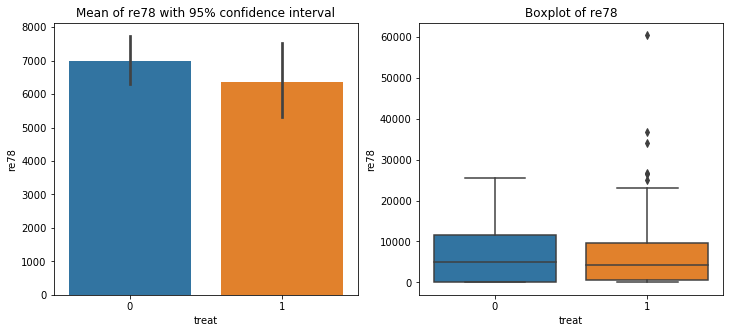

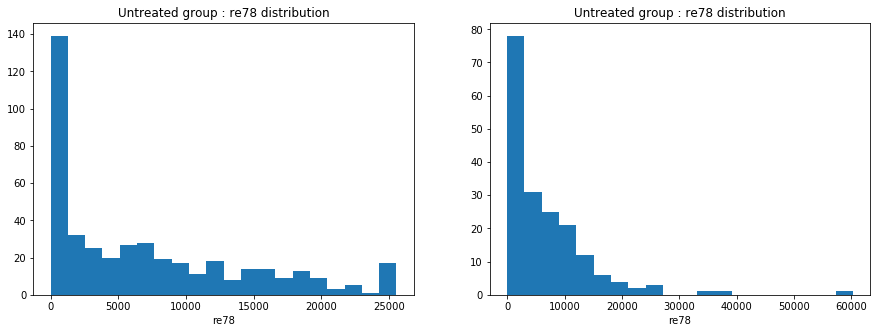

In [32]:
plot_salaries(data, years=['78'])

It seems from the data that the treatement is either useless, or even reduce the income in later years. However, with the 95% confidence interval error bar, it would seem that the treatement doesn't do any significant change.  

We take a look at the distribution if the "re78" feature in the two groups. They seem hardly comparable.

#### 1.E) Eliminating outliers

Looking at the boxplot of the re78 feature among the two group, we clearly see that there are outliers.    

We can remove these outliers, in order to be able to compare the distributions. Empirically, we see that most of the salary are below 28000 :

In [11]:
data_cleaned = data[data.re78 < 28000]

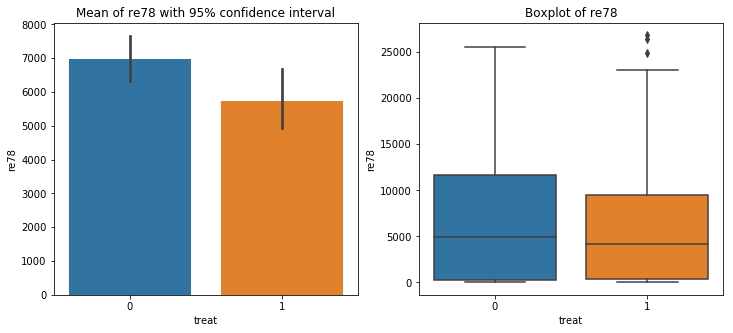

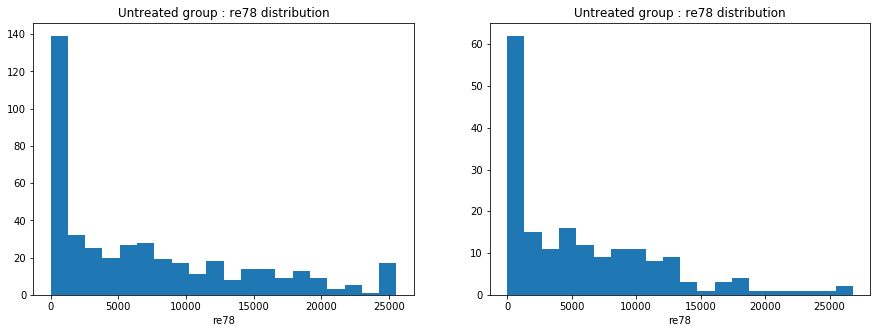

In [33]:
plot_salaries(data_cleaned, years=['78'])

In [34]:
#Some stats numbers for untreated people
data_cleaned[(data_cleaned.treat==0)].re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [35]:
#Some stats numbers for treated people
data_cleaned[(data_cleaned.treat==1)].re78.describe()

count      182.000000
mean      5733.721940
std       6093.361164
min          0.000000
25%        338.649875
50%       4164.272500
75%       9511.635000
max      26817.600000
Name: re78, dtype: float64

Without the outliers, it become a bit more likely that the treatement actually reduced the salaries. The salary median for the untreated group lies at 4975\$, whereas for the treated group it is 4164\$. Almost a 800\$ decrease. The mean tells us the same story, but we prefer to use the median since it is more robust.

Looking at the distribution, boxplot and statistical measures, we can say that there seem to be more people with high salaries in the first group.

#### 1.F) Naive conclusion

From this naive analysis, we would say that instead of increasing the salaries, the treatement actually decreases the salary for the treated group.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.



#### Data cleaning

Just like in the naive analysis, we will remove the outliers, but this time from all salaries.

In [15]:
data_c = data[(data.re78 < 28000) & (data.re75 < 12500) & (data.re74 < 30000)]

Let's make some plots for all features. We still see some points that seem to be outliers, but that is mainly caused by the massive amount of unemployed people in each groups that have a salary of 0 :

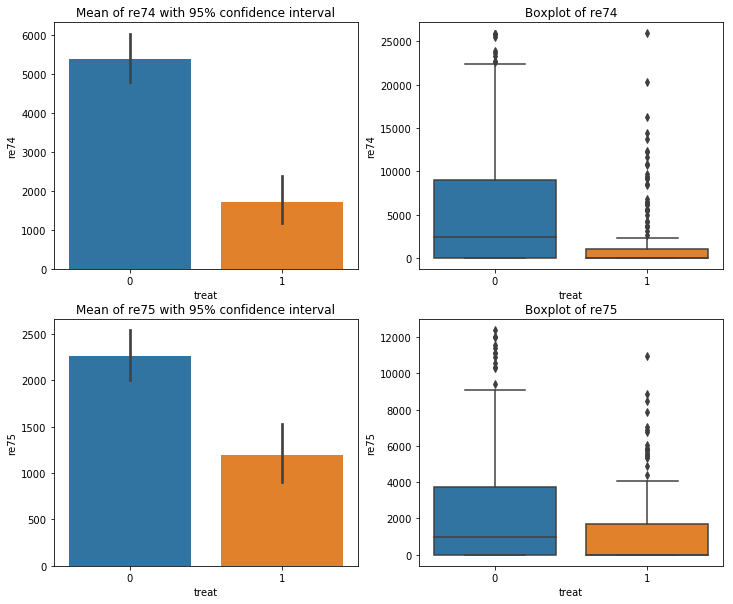

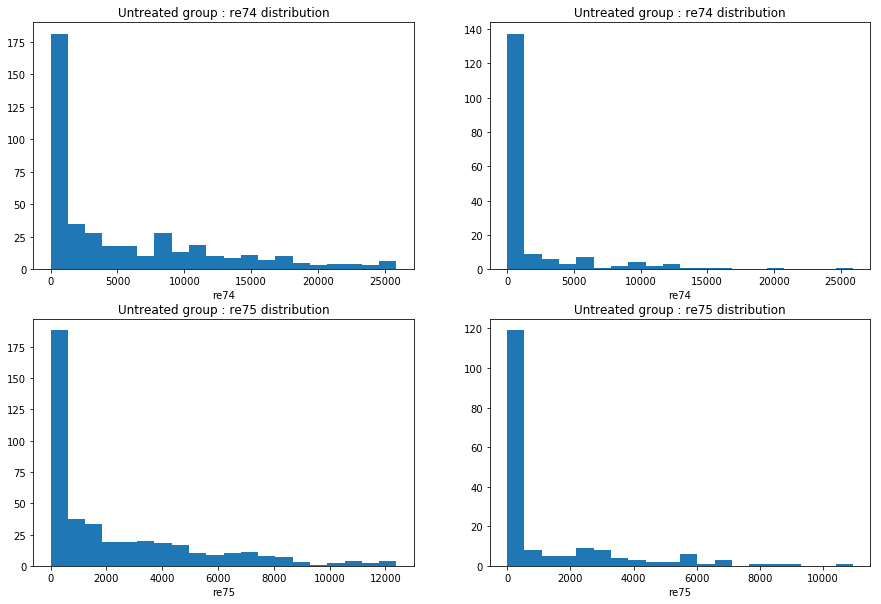

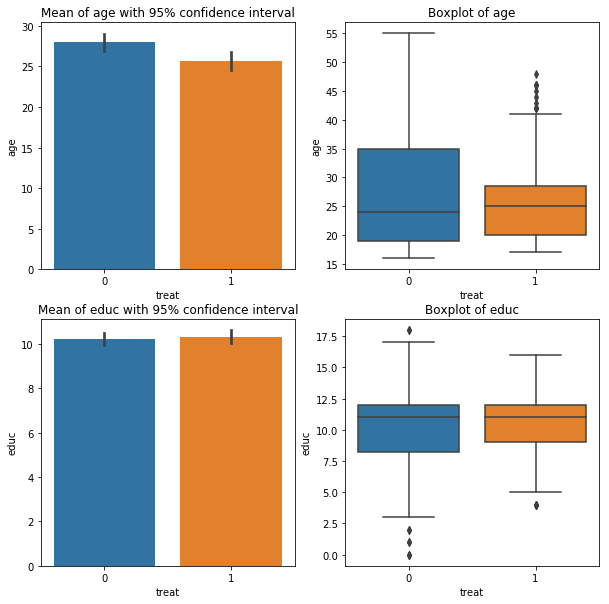

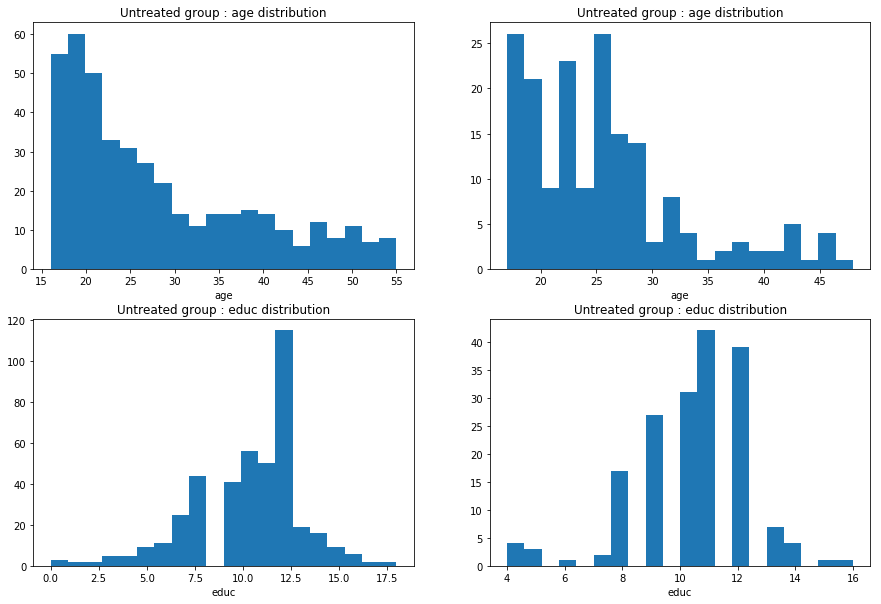

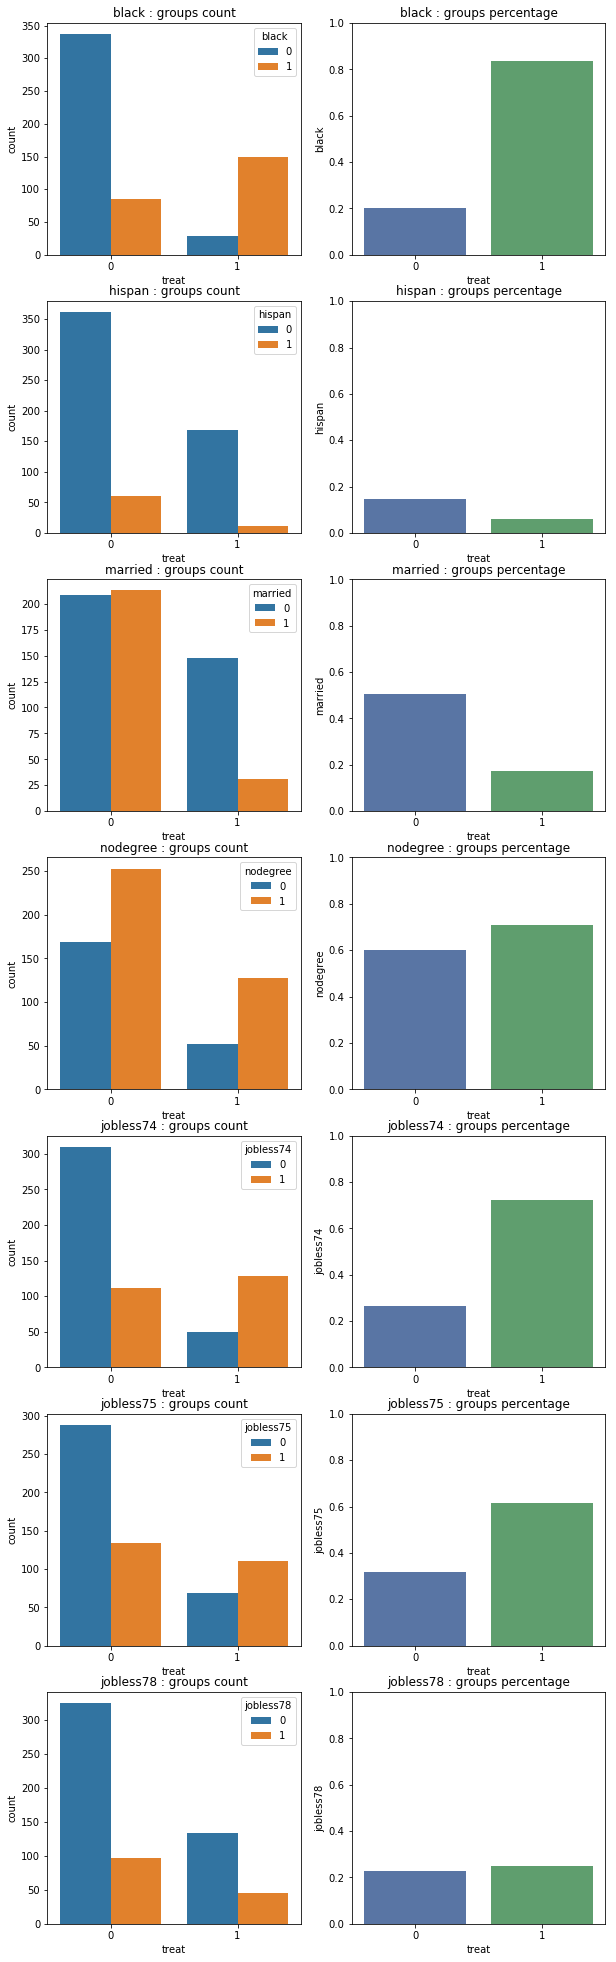

In [38]:
plot_all(data_c, years=['74', '75'])

The population in each group isn't exactly the same, the people in the treated group :   

1) had lower salaries in the previous years
2) were a bit younger (the median is almost the same but the age distribution doesn't goes as high).  
3) had more black people.  
4) had a bit less hispanic people.  
5) were also in majority unmarried.  
6) had also more people that didn't have a degree.   
7) had much more unemployed people in the years before the treatement.  
8) had similar level of unemployment after the treatement. 

From this we can already tell that a lot of of oberved covariates weren't balanced between the two groups, which let us think that the naive conclusion is off.

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)



In [54]:
from sklearn.preprocessing import normalize

def encode_categorical(data):
    """
    Categorize all salaries and age feature by discretizating 
    them for a better propensity score estimation.
    """
    
    categorical_lalonde = data.copy()
    
    #Discretize some values
    categorical_lalonde['cat_age'] = categorical_lalonde['age'].apply(lambda x: int(x))
    categorical_lalonde['cat_re74'] = categorical_lalonde['re74'].apply(lambda x: int(x/100))
    categorical_lalonde['cat_re75'] = categorical_lalonde['re75'].apply(lambda x: int(x/100))
    
    #then drop unused columns
    categorical_lalonde = categorical_lalonde.drop(['id', 'age', 're74', 're75'], axis = 1)
    
    categorical_salary = categorical_lalonde[['cat_age', 'cat_re74', 'cat_re75']]
    
    # get_dummies by default is using one hot encoder
    encoded_salary = pd.get_dummies(categorical_salary, \
        columns=['cat_re74', 'cat_re75', 'cat_age'], prefix=['re74', 're75', 'age'])

    #concat the data and the new features
    encoded_lalonde = pd.concat([data, encoded_salary], axis = 1)
    
    #Drop again the unused columns left
    return encoded_lalonde.drop(['id', 're74', 're75', 're78', 'jobless78', 'age'], axis=1)

In [52]:
def compute_propensity(x):
    """
    Compute the propensity score estimation.
    """
    logistic = LogisticRegression()
    X = x.drop(['treat'], axis=1)
    #Add a column of 1. Its a machine learning trick.
    X = np.c_[np.ones(len(X)), X]
    #Fit the model
    logistic.fit(X=X, y=x['treat'])
    #Return the predictions and the propensity score
    return logistic.predict(X), logistic.predict_proba(X)

prediction, propensity = compute_propensity(encode_categorical(data_c))
print(propensity[:5])

[[ 0.49349863  0.50650137]
 [ 0.38201176  0.61798824]
 [ 0.23902952  0.76097048]
 [ 0.09211745  0.90788255]
 [ 0.0716303   0.9283697 ]]


In [53]:
#See the percentage of correct labels from the regression
correct = np.count_nonzero(prediction == data_c.treat)
print("Accuracy : {} %".format(100*correct/len(prediction)))

Accuracy : 91.01497504159734 %


In our feature, we don't include the 1978 salary or 1978 jobless indicator, since they are post-treatement features.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?




In [19]:
import networkx as nx

Here we will use the networkx library to create a bipartite graph. Each side of the graph is created from the treated or untreated group. Between each node of those groups we will add edges with a weight that grows smaller as the propensity score differs.  
Finally, using a method of bipartite graphs, we will find the maximum weight matching, that is the best edge for each node. The method also ensures that each node is matched with only one other.

In [20]:
def balance_data(data, propensity):
    """
    Find the best matching between the treated and untreated group using the propensity score.
    """
    # Graph initialization
    B = nx.Graph()

    # Split the ids between treated and non treated
    treated = data.loc[data['treat'] == 1].id
    not_treated = data.loc[data['treat'] == 0].id

    # Add the two sets of ids in the bipartite graph
    B.add_nodes_from(treated, bipartite = 0)
    B.add_nodes_from(not_treated, bipartite = 1)

    # Split the propensity scores between treated and not treated
    score_treated = propensity[np.where(data['treat'] == 1)]
    score_nontreated = propensity[np.where(data['treat'] == 0)]

    # For each node of the first set, we add an edge to every nodes of the second set
    for i, st in enumerate(score_treated):
        for j, sn in enumerate(score_nontreated):
            # The weight is 1 minus the absolute distance of propensity scores, since the 
            # matching algorithm maximizes the weight.
            B.add_edge(treated.iloc[i], not_treated.iloc[j], weight = 1.0 - np.abs(st[1] - sn[1]))       

    #Find the best match
    matching = nx.max_weight_matching(B)
    
    return matching

matching = balance_data(data_c, propensity)

In [21]:
#number of match
len(list(matching))

358

In [22]:
# Extract the balanced dataset using the matching
def match_data(data, matching):
    reduced_data = data.set_index('id')
    
    #Find the ids of the matched entries
    reduced_ids = matching.keys()

    return reduced_data.loc[reduced_ids]

reduced_data = match_data(data_c, matching)
reduced_data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,jobless74,jobless75,jobless78
id,,,,,,,,,,,,,
PSID411,0,18,10,1,0,0,1,0.0,0.0,5306.516,1,1,0
NSW25,1,18,10,1,0,0,1,0.0,0.0,11163.170,1,1,0
PSID401,0,17,10,1,0,0,1,0.0,0.0,1053.619,1,1,0
NSW29,1,17,10,1,0,0,1,0.0,0.0,16218.040,1,1,0
PSID398,0,17,8,1,0,0,1,0.0,0.0,4520.366,1,1,0


Now lets plots again the features :

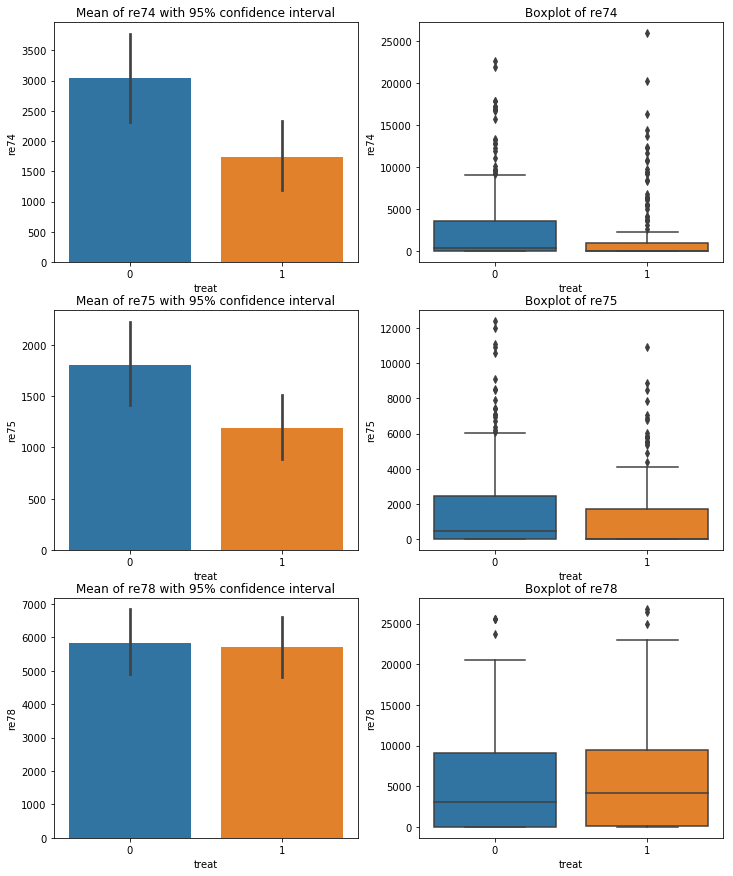

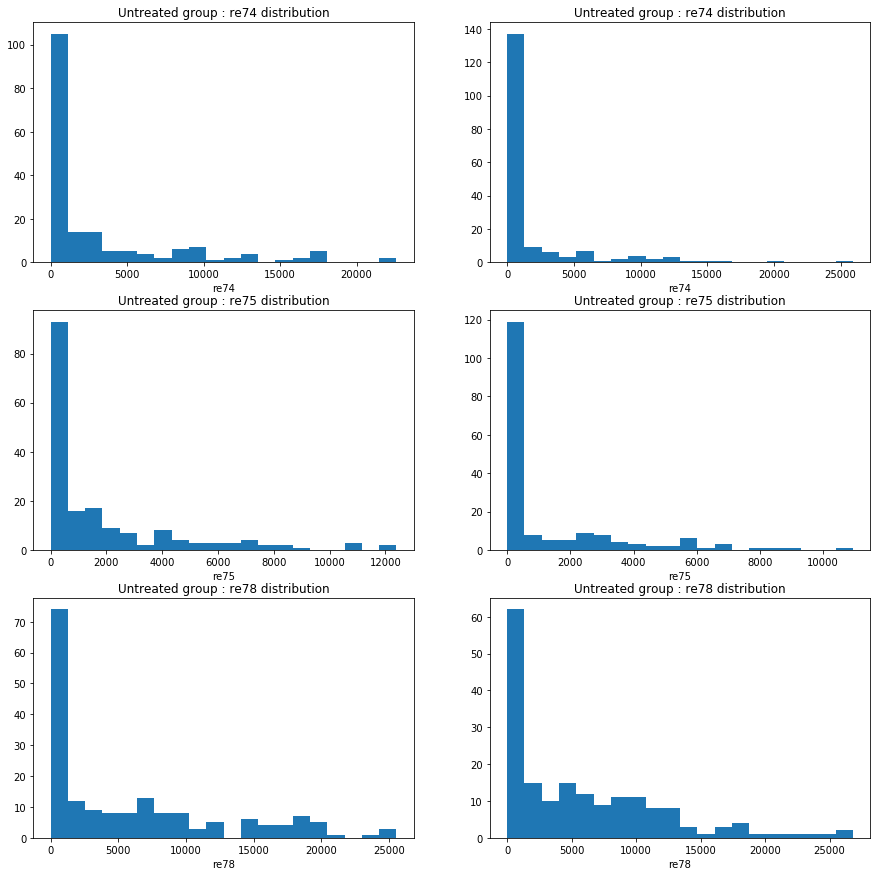

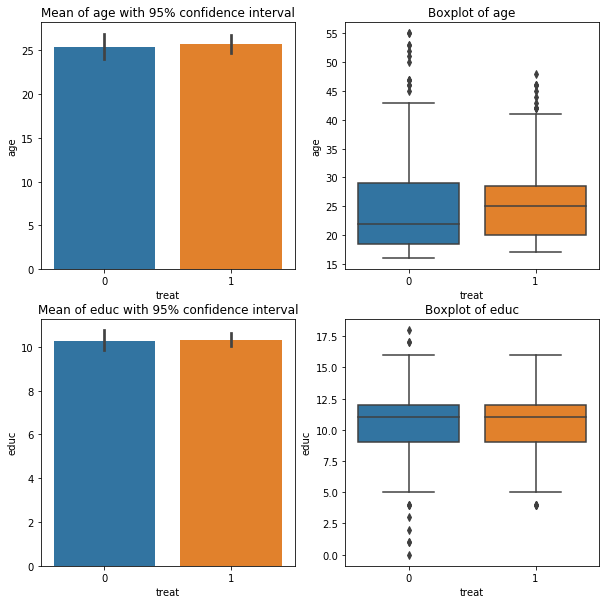

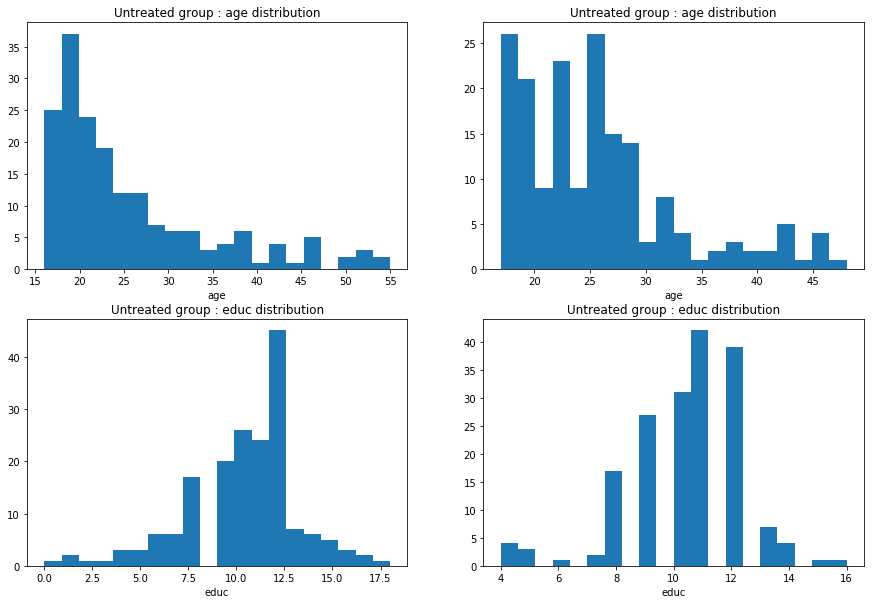

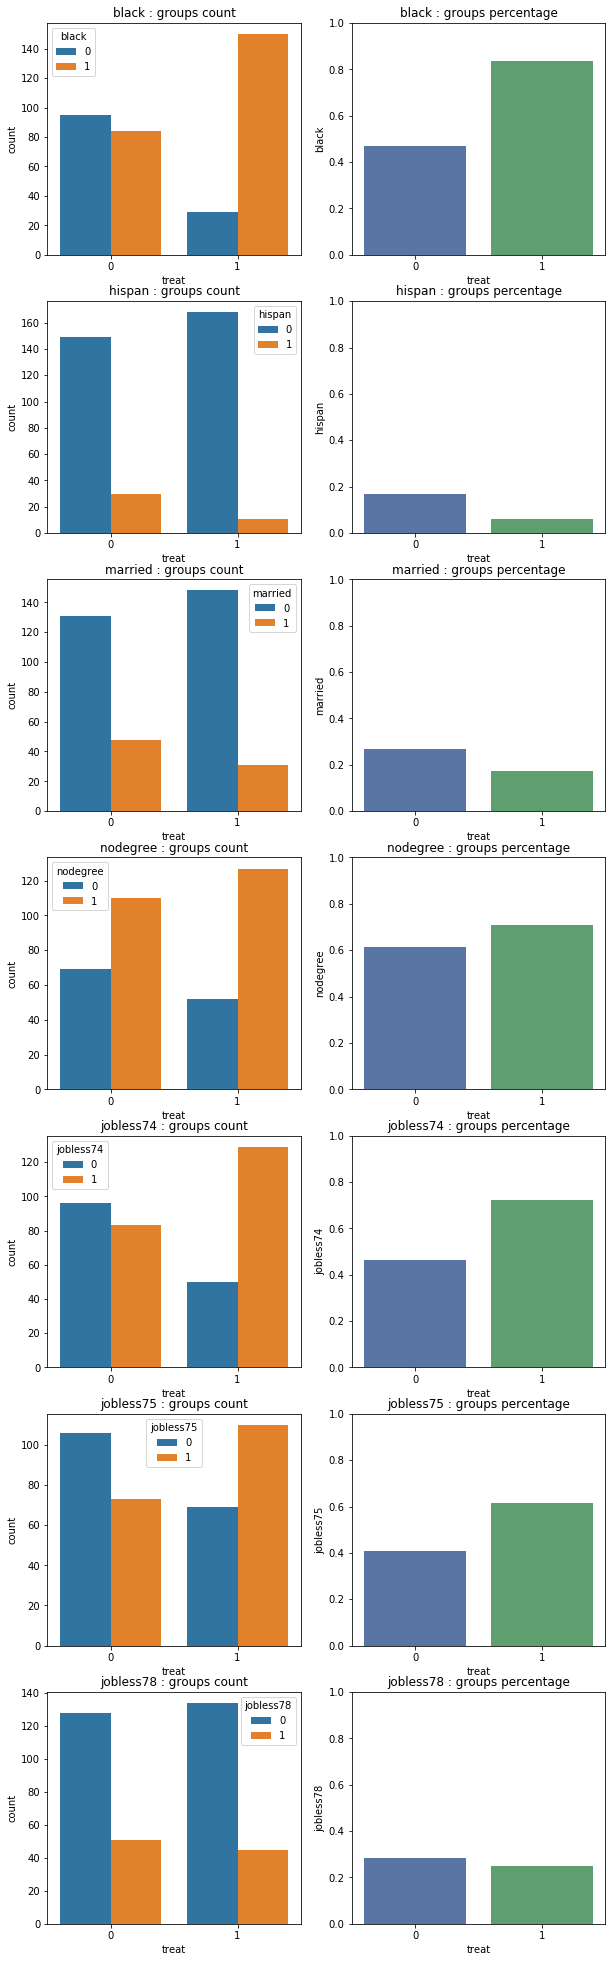

In [39]:
plot_all(reduced_data)

As expected, a lot of features are more balanced now between the two groups, more or less. Thus we are closed to being able to draw a more likely conclusion, but we still don't know about the repartition of the unobserved covariates.

Also, no all of the features are really well balanced, but one in particular is really off: the repartition of black persons.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


We use the same method as before, but this time we force the matched entries to have the same value for the balck feature :

In [24]:
def balance_data_black_equal(data, propensity):
    # Graph initialization
    B = nx.Graph()

    # Split the ids between treated and non treated
    treated = data.loc[data['treat'] == 1][['id', 'black']]
    not_treated = data.loc[data['treat'] == 0][['id', 'black']]

    # Add the two sets of ids in the bipartite graph
    B.add_nodes_from(treated.id, bipartite = 0)
    B.add_nodes_from(not_treated.id, bipartite = 1)

    # Split the propensity scores between treated and not treated
    score_treated = propensity[np.where(data['treat'] == 1)]
    score_nontreated = propensity[np.where(data['treat'] == 0)]

    # For each node of the first set, we add an edge to every nodes of the second set
    for i, st in enumerate(score_treated):
        for j, sn in enumerate(score_nontreated):
            #force the matching to have the same black feature
            if treated.black.iloc[i] == not_treated.black.iloc[j]:
                B.add_edge(treated.id.iloc[i], not_treated.id.iloc[j], weight = 1.0 - np.abs(st[1] - sn[1]))
            # The weight is 1 over the absolute distance of propensity scores, since the 
            # matching algorithm maximizes the weight.

    matching = nx.max_weight_matching(B)
    
    return matching

matching_black = balance_data_black_equal(data_c, propensity)

In [25]:
#number of match
len(list(matching_black))

228

In [26]:
reduced_data_forced = match_data(data_c, matching_black)
reduced_data_forced.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,jobless74,jobless75,jobless78
id,,,,,,,,,,,,,
PSID411,0,18,10,1,0,0,1,0.0,0.0,5306.516,1,1,0
NSW25,1,18,10,1,0,0,1,0.0,0.0,11163.170,1,1,0
PSID401,0,17,10,1,0,0,1,0.0,0.0,1053.619,1,1,0
NSW29,1,17,10,1,0,0,1,0.0,0.0,16218.040,1,1,0
PSID398,0,17,8,1,0,0,1,0.0,0.0,4520.366,1,1,0


Plots of all features : 

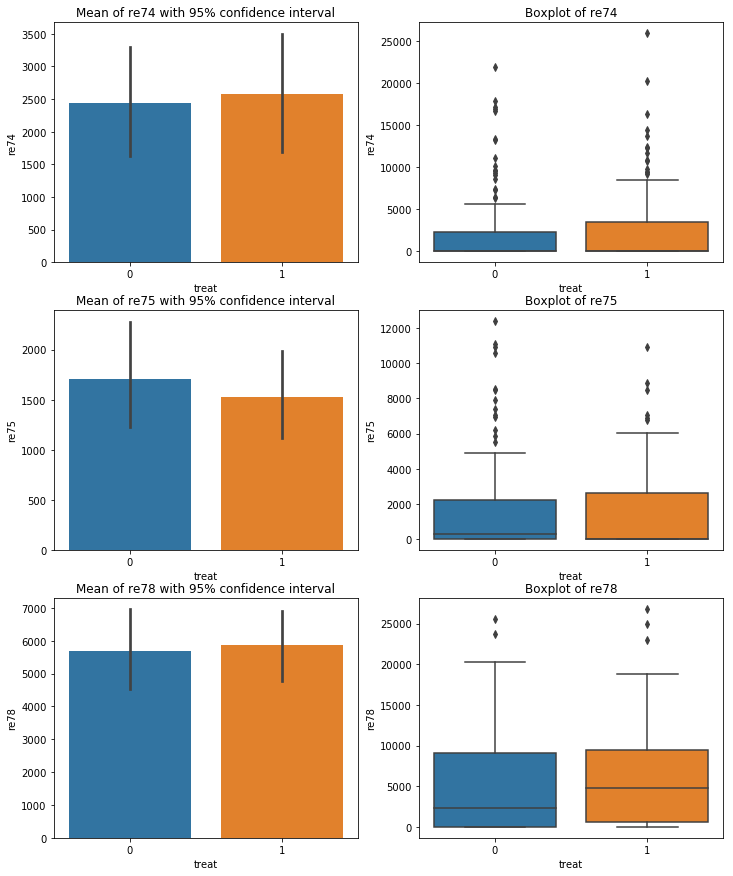

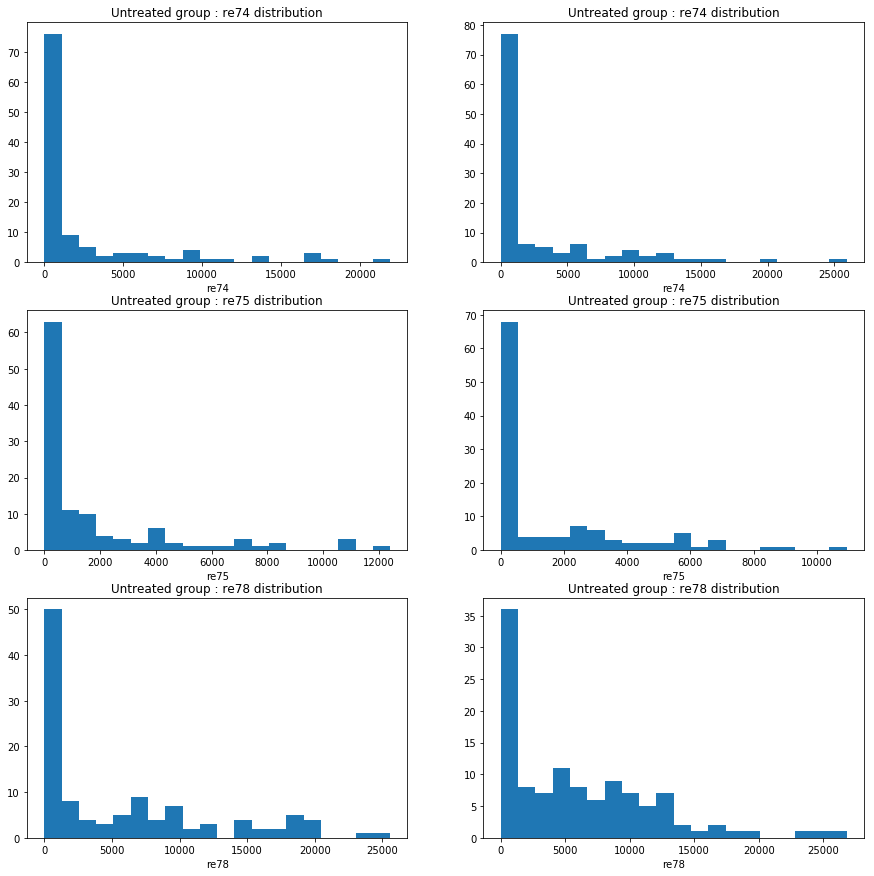

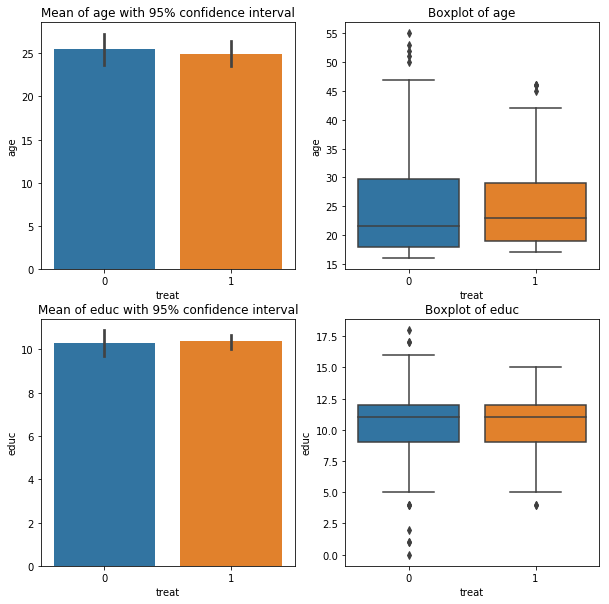

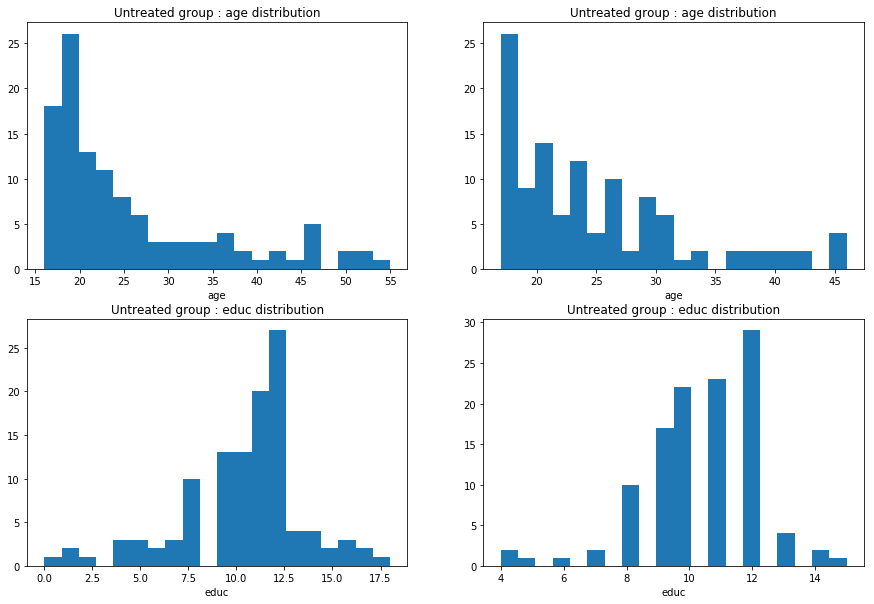

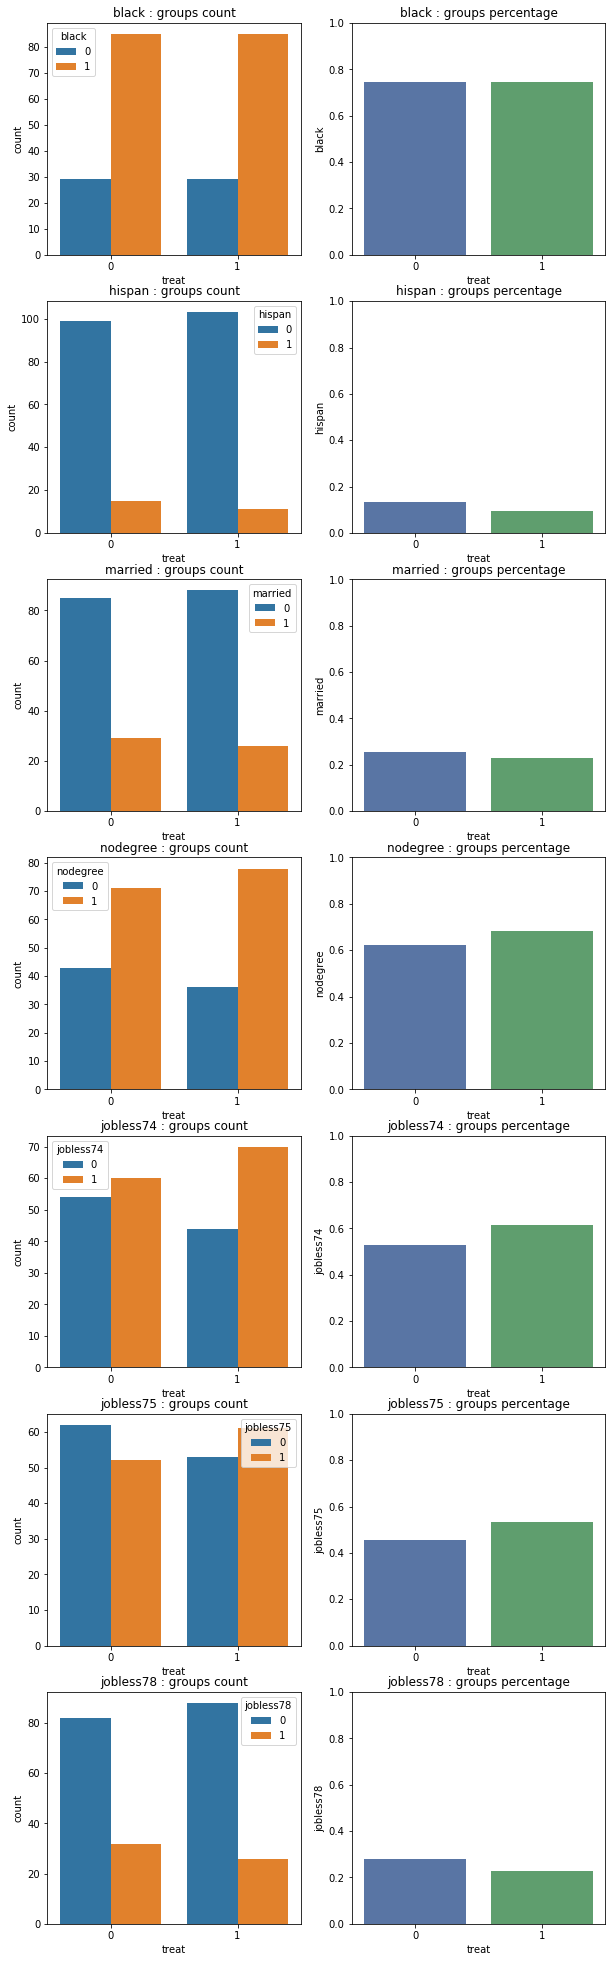

In [40]:
plot_all(reduced_data_forced)

We now see that all the features are pretty well balanced. Just balancing the proportion of black people was sufficient to balance the other features.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?



Lets plot the salaries of 1978 for the last time :

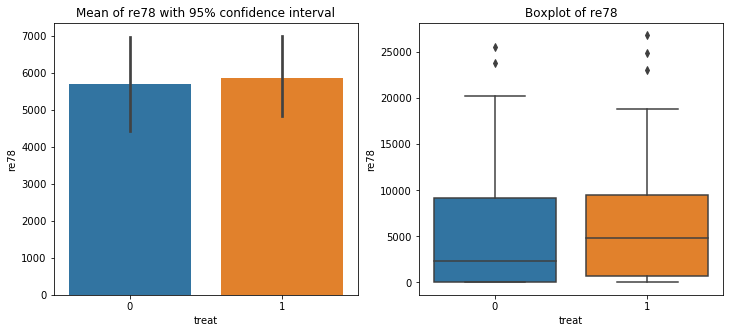

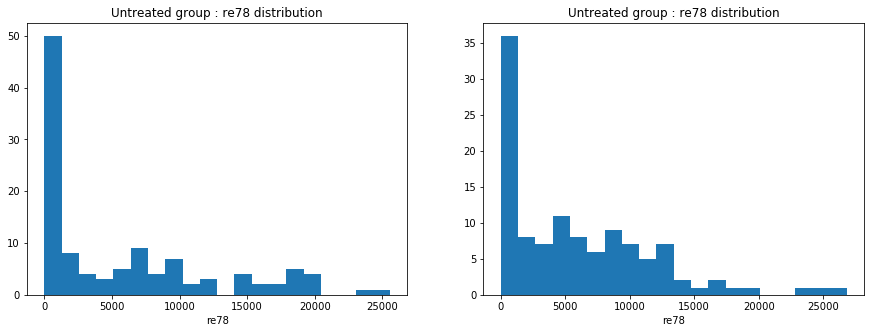

In [41]:
plot_salaries(reduced_data_forced, years=['78'])

In [42]:
#Some stats numbers for untreated people
reduced_data_forced[(reduced_data_forced.treat==0)].re78.describe()

count      114.000000
mean      5684.490081
std       6706.722138
min          0.000000
25%          0.000000
50%       2366.579000
75%       9146.758000
max      25564.670000
Name: re78, dtype: float64

In [43]:
#Some stats numbers for treated people
reduced_data_forced[(reduced_data_forced.treat==1)].re78.describe()

count      114.000000
mean      5862.202865
std       5882.725697
min          0.000000
25%        653.236400
50%       4832.093000
75%       9511.635000
max      26817.600000
Name: re78, dtype: float64

We can observe on the plots that the distribution of salaries is better for high values. The boxplots show us that not only did the median of the salaries significantly increase, the first and third quartile also increased, which mean that all levels of salaries improved. 

On the untreated group the median of the salary was at 2366\$ before the treatement, now with the treatement it jumped to 4832\$. The first quartile directly jumped from 0 to 653\$, and the third one from 9146 to 9511\$.

But let's not forget we only matched people on the observed covariates, so there could still be some determining factors we couldn't see.


## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

#### Part 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).




#### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

